### Image Classification with EfficientNetB0 - Keras Hub (Advanced Level)

This notebook demonstrates an advanced-level image classification task using a pretrained EfficientNetB0 model from Keras Applications.  


In [ ]:
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

### Load the dataset  
The Rock-Paper-Scissors dataset is loaded from TensorFlow Datasets.  
It provides a more complex image classification task with multiple classes.


In [ ]:
dataset, dataset_info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
data_train, data_test = dataset["train"].batch(64), dataset["test"].batch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PTS7IH_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.PTS7IH_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Apply data augmentation  
This block sets up moderate data augmentation techniques like flipping and zooming.  
These transformations help improve model generalization.


In [ ]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1)
])

### Load EfficientNetB0 model  
EfficientNetB0 is imported from Keras Applications as the base model.  
The top layer is excluded so we can add custom classification layers.


In [ ]:
base_model = keras.applications.EfficientNetB0(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze the base model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Build the full model  
This cell builds a full model by stacking custom layers on top of the EfficientNet base.  
It includes a global pooling layer and dense softmax layer for classification.


In [ ]:
inputs = keras.Input(shape=(300, 300, 3))  # Rock-Paper-Scissors images are 300x300
x = keras.layers.Resizing(224, 224)(inputs)  # Resize using Keras layer
x = data_augmentation(x)  # Apply augmentation
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(3, activation="softmax")(x)  # 3 classes: Rock, Paper, Scissors
model = keras.Model(inputs, x)

In [ ]:
# Compile the model with a learning rate scheduler
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1500, decay_rate=0.85
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


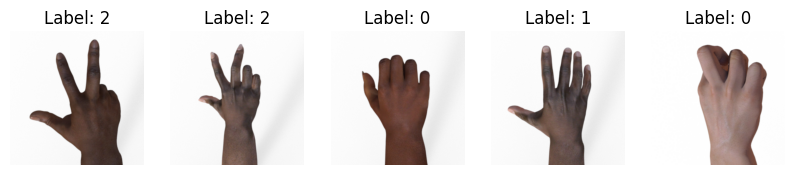

In [ ]:
# Visualize some images from dataset
sample_images, sample_labels = next(iter(data_train.take(1)))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(sample_images[i].numpy().astype("uint8"))
    axes[i].set_title(f"Label: {sample_labels[i].numpy()}")
    axes[i].axis("off")
plt.show()

In [ ]:
# Train the model
history = model.fit(data_train, validation_data=data_test, epochs=5)  # Moderate epochs

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - accuracy: 0.8374 - loss: 0.4379 - val_accuracy: 0.7366 - val_loss: 0.5692
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.9934 - loss: 0.0361 - val_accuracy: 0.7554 - val_loss: 0.5312
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9965 - loss: 0.0225 - val_accuracy: 0.6909 - val_loss: 1.0613
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step - accuracy: 0.9986 - loss: 0.0144 - val_accuracy: 0.6989 - val_loss: 1.0561
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9977 - loss: 0.0107 - val_accuracy: 0.7151 - val_loss: 0.9215


### Plot training accuracy and loss  
This section plots graphs of model accuracy and loss over the training epochs.  
It helps assess model performance and potential overfitting.


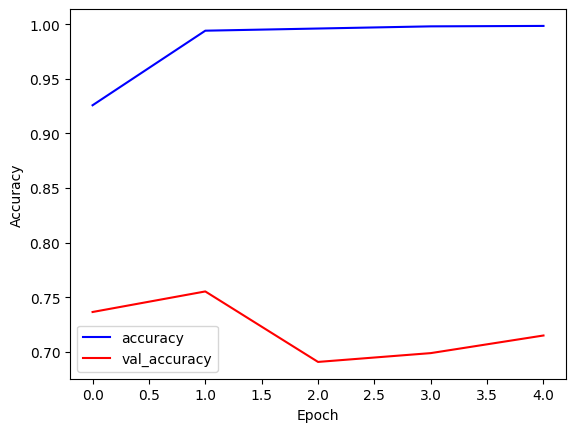

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='val_accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step


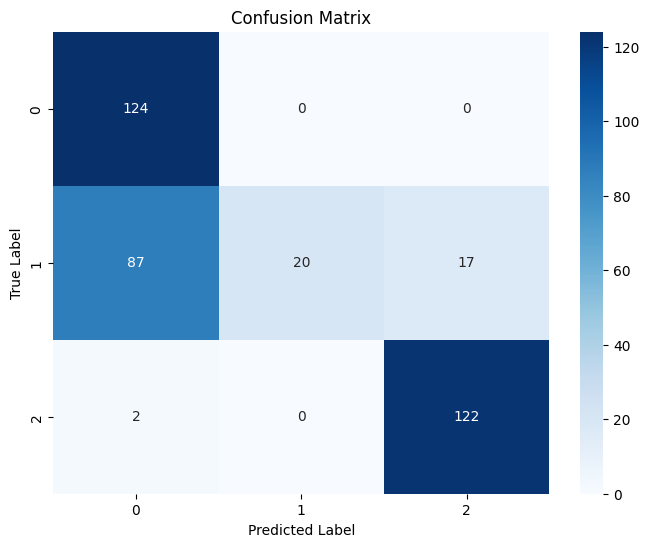

In [ ]:
# Generate predictions and confusion matrix
y_pred = np.argmax(model.predict(data_test), axis=1)
y_true = np.concatenate([y.numpy() for _, y in data_test], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(3), yticklabels=range(3))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()